# Import libraries and files

In [1]:
import pickle
from dPCA import dPCA
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [2]:
def pickle_this(thing_to_pickle, file_name):
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    with open(pickle_file, 'rb') as file:
        return pickle.load(file)

# Phase 2: Freely moving

Each recording is an ephysrecording instance; the documentation is as follows: 

A class for an ephys recording after being spike sorted and manually
curated using phy. Ephys recording must have a phy folder.


    Attributes:
        path: str, relative path to the phy folder
            formatted as: './folder/folder/phy'
        subject: str, subject id who was being recorded
        event_dict: dict, start and stop times for events
            keys: str, name of event types
            values: np.array, d =(n,2), each 2D array is the start and stop time 
            in ms for each event, n = number of events of type key
        sampling_rate: int, sampling rate of the ephys device
            in Hz, standard in the PC lab is 20,000Hz
        timestamps_var: numpy array, all spike timestamps
            of good and mua units (no noise unit-generated spikes)
        unit_array: numpy array, unit ids associated with each
            spike in the timestamps_var
        labels_dict: dict, keys are unit ids (str) and
            values are labels (str)
        unit_timestamps: dict, keys are unit ids (int), and
            values are numpy arrays of timestamps for all spikes
            from "good" units only
        spiketrain: np.array, spiketrain of number of spikes
            in a specified timebin
        unit_spiketrains: dict, spiketrains for each unit
            keys: str, unit ids
            values: np.array, number of spikes per specified timebin
        unit_firing_rates: dict, firing rates per unit
            keys: str, unit ids
            values: np.arrays, firing rate of unit in a specified timebin
                    calculated with a specified smoothing window

    Methods: (all called in __init__)
        get_unit_labels: creates labels_dict
        get_spike_specs: creates timestamps_var and unit_array
        get_unit_timestamps: creates unit_timestamps dictionary


All recordings have been put into an instance of the class type ephysrecordingcollection.
Big picture is that phase2_collection has an attribute called collection which is a dictionary of 
recording names: recording objects. 

In [14]:
phase2_collection = unpickle_this('phase2_collection.pkl')

In [15]:
is_first = True
for recording_name, recording in phase2_collection.collection.items():
    if is_first:
        print('Example recording:')
        print(recording_name)
        print("")
        print('Event Types:')
        print(recording.event_dict.keys())
        print("")
        print('Number of units:')
        print(len(recording.unit_timestamps.keys()))
        is_first = False

Example recording:
20230803_101331_1_merged.rec

Event Types:
dict_keys(['acquisition', 'recall', 'cagemate', 'novel', 'exposure 1', 'exposure 2', 'exposure 3'])

Number of units:
52


In [16]:
phase2_collection.collection.items()

dict_items([('20230803_101331_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F3E150>), ('20230803_121318_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F40080>), ('20230803_141047_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F426C0>), ('20230804_121600_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F48A10>), ('20230804_141009_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F4B8C0>), ('20230817_100823_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F4DB50>), ('20230817_113746_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F4FC50>), ('20230818_115728_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F56120>), ('20230818_133620_1_merged.rec', <multirecording_spikeanalysis.EphysRecording object at 0x0000021876F57D40>)

Here is another class I made for spike analysis specifically. 

Parameters that you should feel free to play with are smoothin_window and timebin (both in ms).

    Timebin:
        window for each element in all the arrays (spiketrains, firing rates, etc.).
    Smoothing window:
        the rolling average window size to be used when calculating firing rates. 

In [17]:
# PCA analysis parameters
phase2_analysis = spike.SpikeAnalysis_MultiRecording(
    phase2_collection,
    smoothing_window = 100, #100
    timebin = 40, #40
    ignore_freq = 0.5)

All set to analyze


In [18]:
LT_matrix_phase2, transformed_matrix, key, coefficients, LT_explained_variance_ratios_phase2 = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=6, events=['cagemate'])
ST_matrix_phase2, transformed_matrix, key, coefficients, ST_explained_variance_ratios_phase2 = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=6, events=['recall'])
acq_matrix_phase2, transformed_matrix, key, coefficients, acq_explained_variance_ratios_phase2 = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=6, events=['acquisition'])
novel_matrix_phase2, transformed_matrix, key, coefficients, novel_explained_variance_ratios_phase2 = phase2_analysis.PCA_matrix_generation(equalize=3, pre_window=6, events=['novel'])

(225, 215)


## Perform CCA for each combination of conditions

In [43]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(LT_matrix_phase2, novel_matrix_phase2)

# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(LT_matrix_phase2, novel_matrix_phase2)
 
# Score the CCA model
LTnov_score = cca.score(LT_matrix_phase2, novel_matrix_phase2)
 
# Print the score
print(LTnov_score)

0.48844959066156407


In [67]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(ST_matrix_phase2, novel_matrix_phase2)
 
# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(ST_matrix_phase2, novel_matrix_phase2)
 
# Score the CCA model
STnov_score = cca.score(ST_matrix_phase2, novel_matrix_phase2)
 
# Print the score
print(STnov_score)

0.5775212985448898


In [26]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(LT_matrix_phase2, ST_matrix_phase2)
 
# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(LT_matrix_phase2, ST_matrix_phase2)
 
# Score the CCA model
LTST_score = cca.score(LT_matrix_phase2, ST_matrix_phase2)
 
# Print the score
print(LTST_score)

0.4969363536175267


In [27]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(LT_matrix_phase2, acq_matrix_phase2)
 
# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(LT_matrix_phase2, acq_matrix_phase2)
 
# Score the CCA model
LTacq_score = cca.score(LT_matrix_phase2, acq_matrix_phase2)
 
# Print the score
print(LTacq_score)

0.43914723268444555


In [28]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(ST_matrix_phase2, acq_matrix_phase2)
 
# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(ST_matrix_phase2, acq_matrix_phase2)
 
# Score the CCA model
STacq_score = cca.score(ST_matrix_phase2, acq_matrix_phase2)
 
# Print the score
print(STacq_score)

0.3151548778585765


In [39]:
from sklearn.cross_decomposition import CCA

# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(novel_matrix_phase2, acq_matrix_phase2)
 
# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(novel_matrix_phase2, acq_matrix_phase2)
 
# Score the CCA model
novacq_score = cca.score(novel_matrix_phase2, acq_matrix_phase2)
 
# Print the score
print(novacq_score)

0.20899191521785787


In [ ]:
# Create an instance of the CCA class with two components
cca = CCA(n_components=5)
 
# Fit the CCA model to X and Y
cca.fit(novel_matrix_phase2, acq_matrix_phase2)
 
# Transform X and Y to canonical variables
X_c, Y_c = cca.transform(novel_matrix_phase2, acq_matrix_phase2)

# inverse transform of X_c to get X_c_hat and Y_c to get Y_c_hat
# Same steps for subspace analysis to get variance in original space
# Calculate correlation coefficient between X_c and Y_c (five coef for five components)

# Score the CCA model
novacq_score = cca.score(novel_matrix_phase2, acq_matrix_phase2)
 
# Print the score
print(novacq_score)

## Plot resulting CCA score values

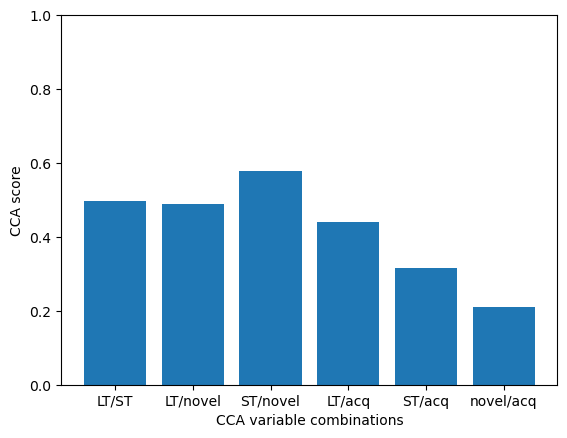

In [60]:
fig, ax = plt.subplots()
allscores = [LTST_score, LTnov_score, STnov_score, LTacq_score, STacq_score, novacq_score]
labels = ["LT/ST", "LT/novel", "ST/novel", "LT/acq", "ST/acq", "novel/acq"]
plt.bar(x=np.arange(len(allscores)),height=allscores)
ax.set_xticks(np.arange(len(allscores)))
ax.set_xticklabels(labels)
ax.set_ylim([0,1])
ax.set_xlabel("CCA variable combinations")
ax.set_ylabel("CCA score")
plt.show()